In [2]:
import math
import re
import shutil

import graphviz
import pandas as pd
import numpy as np
from dtreeviz.trees import dtreeviz
from fastai.tabular.all import (
    add_datepart,
    cont_cat_split,
    Categorify,
    FillMissing,
    TabularPandas,
)
from fastbook import (
    Path,
    URLs,
    load_pickle,
    save_pickle,
)
from kaggle import api
from sklearn.tree import DecisionTreeRegressor, export_graphviz

### Categorical embeddings


Entity embedding not only reduces memory usage and speeds up neural networks compared with one-hot encoding, but more importantly by mapping similar values close to each other in the embedding space it reveals the intrinsic properties of the categorical variables...



An embedding layer is exactly equivalent to placing an ordinary linear layer after every one-hot-encoded input layer.


We provide the model fundamentally categorical data about discrete entities (e.g., German states or days of the week), and then the model learns an embedding for these entities that defines a continuous notion of distance between them. Because the embedding distance was learned based on real patterns in the data, that distance tends to match up with our intuitions.

### Beyond deep learning

Recent studies have shown that the vast majority of datasets can be best modeled with just two methods:

1) Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies).

2) Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language).

The critical step of interpreting a model of tabular data is significantly easier for decision tree ensembles.

So, ensembles of decision trees are our first approach for analyzing a new tabular dataset.

The exception to this guideline is when the dataset meets one of these conditions:

1) There are some high-cardinality categorical variables that are very important ("cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
2) There are some columns that contain data that would be best understood with a neural network, such as plain text data.

### The dataset


The dataset is from the [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data) Kaggle competition, which has the following description: "The goal of the contest is to predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations."

In [3]:
!pip install kaggle

In [4]:
creds = '' # replace this

In [5]:
# only run once

cred_path = Path('~/.kaggle/kaggle.json').expanduser()

if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
# download dataset from Kaggle

competition = "bluebook-for-bulldozers"

path = URLs.path(competition)
path

Path('/home/david/.fastai/archive/bluebook-for-bulldozers')

In [7]:
Path.BASE_PATH = path

In [8]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli(competition, path=path)
    shutil.unpack_archive(str(path/f'{competition}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('TrainAndValid.csv'),Path('Machine_Appendix.csv'),Path('Valid.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('random_forest_benchmark_test.csv'),Path('median_benchmark.csv')]

#### Look at the Data

The Data explains that the key fields in train.csv are:

- SalesID:: The unique identifier of the sale.
- MachineID:: The unique identifier of a machine. A machine can be sold multiple times.
- saleprice:: What the machine sold for at auction (only provided in train.csv).
- saledate:: The date of the sale.



TIP

It's a good idea to specify `low_memory=False` unless Pandas actually runs out of memory and returns an error. The `low_memory` flag, which is True by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

In [9]:
df = pd.read_csv(path / "TrainAndValid.csv", low_memory=False)

In [10]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At this point, a good next step is to handle ordinal columns. This refers to columns containing strings or similar, but where those strings have a natural ordering. For instance, here are the levels of ProductSize:

In [12]:
df["ProductSize"].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [13]:
sizes = "Large", "Large / Medium", "Medium", "Small", "Mini", "Compact"

df['ProductSize'] = df['ProductSize'].astype('category')

df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2747: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


You should think carefully about which metric, or set of metrics, actually measures the notion of model quality that matters to you.

In this case Kaggle tells us what metric to use: root mean squared log error (RMSLE) between the actual and predicted auction prices.

In [14]:
dep_var = "SalePrice"

df[dep_var] = np.log(df[dep_var])

### Decision Trees

A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch.


This sequence of questions is now a procedure for taking any data item, whether an item from the training set or a new one, and assigning that item to a group. Namely, after asking and answering the questions, we can say the item belongs to the same group as all the other training data items that yielded the same set of answers to the questions. 

The basic steps to train a decision tree:


1) Loop through each column of the dataset in turn.
2) For each column, loop through each possible level of that column in turn.
3) Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
4) Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple "model" where our predictions are simply the average sale price of the item's group.
5) After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6) We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each by going back to step 1 for each group.
7) Continue this process recursively, until you have reached some stopping criterion for each group—for instance, stop splitting a group further when it has only 20 items in it.

#### Handling dates


In order to help our algorithm handle dates intelligently, we'd like our model to know more than whether a date is more recent or less recent than another. We might want our model to make decisions based on that date's day of the week, on whether a day is a holiday, on what month it is in, and so forth (as columns).

These columns provide categorical data that we suspect will be useful.

In [15]:
# fastai comes with a function that will do this for us—we just have to pass a column name that contains dates:


df = add_datepart(df, "saledate")
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2006,11,46,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2004,3,13,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004,2,9,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,5,20,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,7,30,23,3,204,False,False,False,False,False,False,1.248307e+09


In [16]:
# let's do the same for the test set

df_test = pd.read_csv(path / "Test.csv", low_memory=False)
df_test = add_datepart(df_test, "saledate")

In [17]:
# new columns

" ".join(column_name for column_name in df.columns if column_name.startswith("sale"))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

#### Using TabularPandas and TabularProc


A second piece of preparatory processing is to be sure we can handle strings and missing data.


We will use fastai's class TabularPandas, which wraps a Pandas DataFrame. To populate a TabularPandas, we will use two TabularProcs, Categorify and FillMissing. A TabularProc is like a regular Transform, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

Categorify is a TabularProc that replaces a column with a numeric categorical column. 

FillMissing is a TabularProc that replaces missing values with the median of the column, and creates a new Boolean column that is set to True for any row where the value was missing.

In [18]:
procs = [Categorify, FillMissing]

TabularPandas will also handle splitting the dataset into training and validation sets for us.

We don't get to see the test set. But we do want to define our validation data so that it has the same sort of relationship to the training data as the test set will have.

In some cases, just randomly choosing a subset of your data points will do that. This is not one of those cases, because it is a time series (if you look at the date range represented in the test set, you will discover that it covers a six-month period from May 2012, which is later in time than any date in the training set)...but it means that if we are going to have a useful validation set, we also want the validation set to be later in time than the training set.

The Kaggle training data ends in April 2012, so we will define a narrower training dataset which consists only of the Kaggle training data from before November 2011, and we'll define a validation set consisting of data from after November 2011.

In [19]:
condition = (df.saleYear < 2011) | (df.saleMonth < 10)
# np.where is a useful function that returns (as the first element of a tuple) the indices of all True values
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx), list(valid_idx))

In [20]:
condition

0         True
1         True
2         True
3         True
4         True
          ... 
412693    True
412694    True
412695    True
412696    True
412697    True
Length: 412698, dtype: bool

TabularPandas needs to be told which columns are continuous and which are categorical. We can handle that automatically using the helper function `cont_cat_split`:

In [21]:
continuous, categorical = cont_cat_split(df, max_card=1, dep_var=dep_var)

In [22]:
to = TabularPandas(df, procs, categorical, continuous, y_names=dep_var, splits=splits)

In [23]:
len(to.train), len(to.valid)

(404710, 7988)

In [24]:
# We can see that the data is still displayed as strings for categories
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [25]:
# However, the underlying items are all numeric
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


The conversion of categorical columns to numbers is done by simply replacing each unique level with a number. The numbers associated with the levels are chosen consecutively as they are seen in a column, so there's no particular meaning to the numbers in categorical columns after conversion.

The exception is if you first convert a column to a Pandas ordered category (as we did for ProductSize earlier).

In [26]:
to.classes["ProductSize"]

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

Since it takes a minute or so to process the data to get to this point, we should save it—that way in the future we can continue our work from here without rerunning the previous steps

In [27]:
save_pickle(path / "to.pkl", to)

In [28]:
# To read this back later, you would type:

to = load_pickle(path / "to.pkl")

#### Creating the decision tree

In [29]:
to = load_pickle(path / "to.pkl")

xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [30]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [31]:
def draw_tree(tree_model, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(
        tree_model,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=False,
        precision=precision,
        **kwargs,
    )

    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

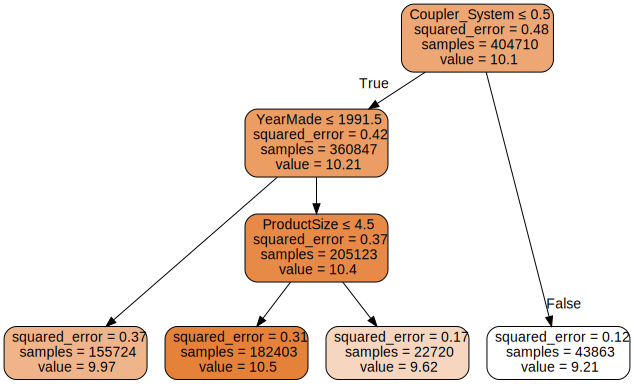

In [32]:
draw_tree(model, xs, size=10, precision=2, leaves_parallel=True)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


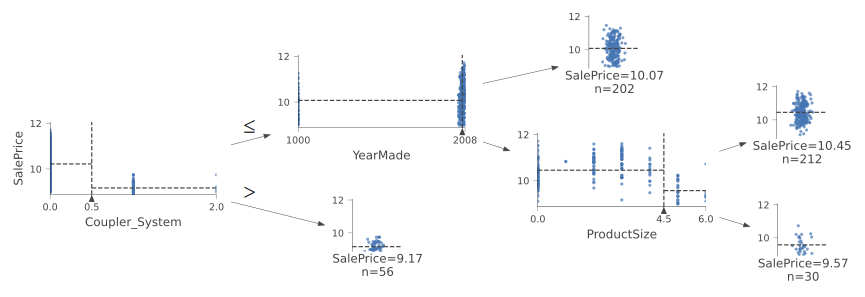

In [33]:
# We can show the same information using Terence Parr's powerful dtreeviz library:
samp_idx = np.random.permutation(len(y))[:500]

dtreeviz(
        model,
        xs.iloc[samp_idx],
        y.iloc[samp_idx],
        xs.columns,
        dep_var,
        fontname='DejaVu Sans',
        scale=1.6,
        label_fontsize=10,
        orientation='LR'
)

This shows a chart of the distribution of the data for each split point.

We can clearly see that there's a problem with our `YearMade` data: there are bulldozers made in the year 1000, apparently! Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing).

Let's fix it.

In [34]:
xs.loc[xs["YearMade"] < 1900, "YearMade"] = 1950

valid_xs.loc[valid_xs["YearMade"] < 1900, "YearMade"] = 1950

That change makes the split much clearer in the tree visualization, even although it doesn't actually change the result of the model in any significant way. This is a great example of how resilient decision trees are to data issues!

In [35]:
model = DecisionTreeRegressor(max_leaf_nodes=4)
model.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

/home/david/anaconda3/envs/fast.ai/lib/python3.9/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


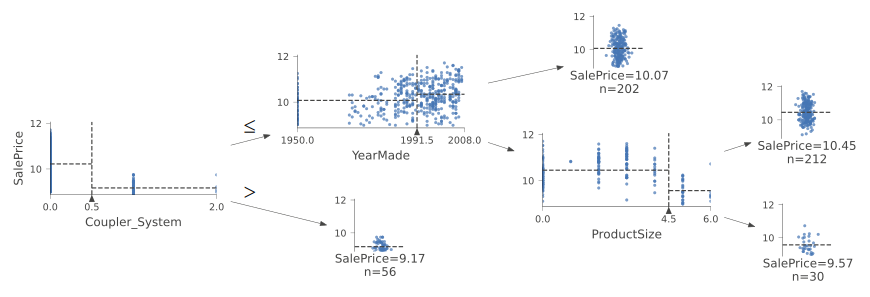

In [36]:
dtreeviz(
        model,
        xs.iloc[samp_idx],
        y.iloc[samp_idx],
        xs.columns,
        dep_var,
        fontname='DejaVu Sans',
        scale=1.6,
        label_fontsize=10,
        orientation='LR'
)

In [37]:
# Let's build a bigger tree

model = DecisionTreeRegressor()
model.fit(xs, y)

DecisionTreeRegressor()

Let's create evaluation functions

In [38]:
def r_mse(pred, y):
    return round(math.sqrt(((pred - y)**2).mean()), 6)

def m_rmse(model, xs, y):
    return r_mse(model.predict(xs), y)

In [39]:
print("training: ", m_rmse(model, xs, y), "validation: ", m_rmse(model, valid_xs, valid_y))

training:  0.0 validation:  0.334935


In [40]:
# Oops—it looks like we might be overfitting pretty badly. Here's why:

model.get_n_leaves(), len(xs)

(324560, 404710)

In [43]:
# We've got nearly as many leaf nodes as data points! Indeed, sklearn's default settings allow it to continue splitting nodes until there is only one item in each leaf node.

model = DecisionTreeRegressor(min_samples_leaf=30)
model.fit(to.train.xs, to.train.y)

m_rmse(model, xs, y), m_rmse(model, valid_xs, valid_y)

(0.251824, 0.322255)

In [44]:
model.get_n_leaves()

10307

#### Categorical variables


In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

**The short answer is: it just works!**

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a get_dummies method.

However, there is not really any evidence that such an approach improves the end result. So, we generally avoid it where possible, because it does end up making your dataset harder to work with.